<a href="https://colab.research.google.com/github/aidan-lew/junk-drawer/blob/main/gpt_ml_fin_forcaster_integrator_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

These are the recourses to make a venv for colab:
https://stackoverflow.com/questions/74244113/how-to-make-virtual-environment-on-google-colab-that-can-be-saved-on-drive
https://colab.research.google.com/drive/1Vg005uKhgt-ZwyQ11-BGceqY0q07qIzF

In [1]:
!pip install datasets
!pip install transformers
!pip install huggingface_hub
!pip install git+https://github.com/huggingface/peft.git
!pip install git+https://github.com/huggingface/accelerate.git
!pip install torch
!pip install googlesearch-python
!pip install GoogleNews
!pip install textblob
!pip install schedule
!pip install time
!pip install telebot
!pip install telethon
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.

# Load FinGPT

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
#have to have access to LLama -  via hugging face
### THIS IS ABlE TO RUN ON a T4!!!
# https://github.com/AI4Finance-Foundation/FinGPT/tree/master/fingpt/FinGPT_Forecaster
# https://github.com/AI4Finance-Foundation/FinGPT/blob/master/FinGPT_Inference_Llama2_13B_falcon_7B_for_Beginners.ipynb
### see how the flow works for these, look at the hugging face page dataset for training.



#### note, this is for the forcaster FinGPT model, which is not specifically for sentiment analysis
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

base_model = AutoModelForCausalLM.from_pretrained(
    'meta-llama/Llama-2-7b-chat-hf',
    trust_remote_code=True,
    device_map="auto",
    torch_dtype=torch.float16,   # optional if you have enough VRAM
)
tokenizer = AutoTokenizer.from_pretrained('meta-llama/Llama-2-7b-chat-hf')

gpt_model = PeftModel.from_pretrained(base_model, 'FinGPT/fingpt-forecaster_dow30_llama2-7b_lora')
gpt_model = gpt_model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/528 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/40.0M [00:00<?, ?B/s]

# Whole pipeline

## Scraper

In [ ]:
from googlesearch import search
from bs4 import BeautifulSoup
import requests

def scrape_news_headlines(ticker, num_articles):
  query = f"{ticker} news" #####find a better url/website because the current one just gets the google web results
  search_results = search(query)
  articles = []
  count = 0
  for url in search_results:
      if count >= num_articles:
          break
      try:
          response = requests.get(url, verify=False, headers={'User-Agent':'Mozilla/5.0'}, #timeout=10
                                  )
          soup = BeautifulSoup(response.text, 'html.parser')
          title = soup.find('title').text if soup.find('title') else 'No title'
          articles.append({'title': title, 'link': url})
          count += 1
      except Exception as e:
          print(f"Error processing {url}: {e}")
  return articles


## Analyzer

In [ ]:
def analyze_news_sentiment(articles):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  gpt_model.to(device)  # Move the model to the device

  sentiments = []
  for article in articles:
      inputs = tokenizer(article['title'], return_tensors='pt', max_length=512, truncation=True)
      inputs = {k: v.to(device) for k, v in inputs.items()}  # Move the input tensors to the device
      outputs = gpt_model(inputs['input_ids'], attention_mask=inputs['attention_mask'])
      sentiment = torch.nn.functional.softmax(outputs.logits, dim=1)
      sentiments.append(sentiment.detach().cpu().numpy())  # Move the sentiment tensor back to the CPU before converting to numpy
      #print(sentiments)
  return sentiments

## Predictor

In [ ]:
import numpy as np
import yfinance as yf
from sklearn.ensemble import HistGradientBoostingRegressor
import pandas as pd

def make_stock_price_prediction(ticker, sentiments):
    stock_data = yf.download(ticker, period='1d', interval='1m')
    #print(stock_data)
    # Extract the positive sentiment score (index 1) from each softmax output
    sentiment_scores = [sentiment[0, 1] for sentiment in sentiments]

    # Create a 1D numpy array from the sentiment scores
    sentiments = np.array(sentiment_scores)

    sentiment_mean = np.mean(sentiments)
    #print(f"Sentiment mean: {sentiment_mean}")

    stock_data['sentiment'] = [sentiment_mean] * len(stock_data)  # Create a new column with the same value repeated for each row
    X = stock_data[['sentiment']]
    y = stock_data['Close']
    #print(stock_data)
    #print(f"X shape: {X.shape}")
    #print(f"y shape: {y.shape}")

    # Fit a HistGradientBoostingRegressor model
    fin_model = HistGradientBoostingRegressor()
    fin_model.fit(X, y)

    # Make a prediction
    prediction_input = pd.DataFrame({'sentiment': [sentiment_mean]})
    #print(f"Prediction input shape: {prediction_input.shape}")

    prediction = fin_model.predict(prediction_input)

    #print(f"Prediction: {prediction}")

    return prediction[0]  # Return the scalar prediction


## Pipeline Function

In [ ]:
def prediction_pipeline():
  ticker = input('ticker')
  num_articles = int(input('number of articles'))
  articles = scrape_news_headlines(ticker, num_articles)
  sentiments = analyze_news_sentiment(articles)
  prediction = make_stock_price_prediction(ticker, sentiments)
  print('\n' f"Predicted stock price for {ticker}: {prediction}")
  #return ticker
  #return num_articles
  #return prediction

In [ ]:
prediction_pipeline()

tickerAAPL
number of articles10


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'finance.yahoo.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.cnbc.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'finance.yahoo.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:


Predicted stock price for AAPL: 214.40040233881786


# Piece by piece

## Scraper

In [ ]:
####### News sources - what about econ data, general news, etc?
#### googlenews API (https://pypi.org/project/GoogleNews/)
### Rueters (https://www.reuters.com/business/)
### https://www.bloomberg.com/
from googlesearch import search
from bs4 import BeautifulSoup
import requests

def scrape_news_headlines(ticker, num_articles):
  query = f"{ticker} news" #####find a better url/website because the current one just gets the google web results
  search_results = search(query)
  articles = []
  count = 0
  for url in search_results:
      if count >= num_articles:
          break
      try:
          response = requests.get(url, verify=False, headers={'User-Agent':'Mozilla/5.0'}, #timeout=10
                                  )
          soup = BeautifulSoup(response.text, 'html.parser')
          title = soup.find('title').text if soup.find('title') else 'No title'
          articles.append({'title': title, 'link': url})
          count += 1
      except Exception as e:
          print(f"Error processing {url}: {e}")
  return articles

In [ ]:
ticker = 'AAPL'
num_articles = 5
articles = scrape_news_headlines(ticker, num_articles)
print(articles)
### returns a [{'':}] list of tuples

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.cnbc.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'finance.yahoo.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.nasdaq.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:110

[{'title': 'AAPL: Apple Inc - Stock Price, Quote and News - CNBC', 'link': 'https://www.cnbc.com/quotes/AAPL'}, {'title': 'No title', 'link': 'https://finance.yahoo.com/quote/AAPL/news/'}, {'title': 'Apple (AAPL) News Headlines | Nasdaq', 'link': 'https://www.nasdaq.com/market-activity/stocks/aapl/news-headlines'}, {'title': 'No title', 'link': 'https://sg.finance.yahoo.com/quote/AAPL/'}, {'title': 'marketwatch.com', 'link': 'https://www.marketwatch.com/investing/stock/aapl'}]


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.marketwatch.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


## Analyzer

In [ ]:
import torch
def analyze_news_sentiment(articles):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  gpt_model.to(device)  # Move the model to the device

  sentiments = []
  for article in articles:
      inputs = tokenizer(article['title'], return_tensors='pt', max_length=512, truncation=True)
      inputs = {k: v.to(device) for k, v in inputs.items()}  # Move the input tensors to the device
      outputs = gpt_model(inputs['input_ids'], attention_mask=inputs['attention_mask'])
      sentiment = torch.nn.functional.softmax(outputs.logits, dim=1)
      sentiments.append(sentiment.detach().cpu().numpy())  # Move the sentiment tensor back to the CPU before converting to numpy
      print(sentiments)
  return sentiments

In [ ]:
ticker = 'AAPL'
num_articles = 5
articles = scrape_news_articles(ticker, num_articles)
sentiments = analyze_news_sentiment(articles)

NameError: name 'tokenizer' is not defined

In [ ]:
sentiments = analyze_news_sentiment(articles)

[array([[[1.6988595e-03, 2.8256273e-02, 1.0302393e-03, ...,
         1.4731156e-02, 1.9216403e-01, 4.3249498e-03],
        [9.3285739e-03, 1.2565035e-01, 2.7878977e-07, ...,
         1.8767979e-02, 2.7468417e-02, 1.4430288e-03],
        [1.9861681e-03, 4.4266836e-04, 1.1267488e-05, ...,
         2.9526176e-02, 3.5546772e-02, 1.2635583e-03],
        ...,
        [8.7134868e-02, 8.1762232e-02, 1.5530892e-01, ...,
         2.5955172e-02, 3.3786733e-02, 3.1461842e-02],
        [4.7745969e-02, 5.5323094e-02, 2.8283855e-02, ...,
         2.4766596e-02, 9.8324986e-03, 2.0155214e-02],
        [5.4839859e-03, 9.5935218e-04, 1.8841110e-02, ...,
         5.7463129e-03, 1.7324112e-02, 5.2585866e-02]]], dtype=float32)]
[array([[[1.6988595e-03, 2.8256273e-02, 1.0302393e-03, ...,
         1.4731156e-02, 1.9216403e-01, 4.3249498e-03],
        [9.3285739e-03, 1.2565035e-01, 2.7878977e-07, ...,
         1.8767979e-02, 2.7468417e-02, 1.4430288e-03],
        [1.9861681e-03, 4.4266836e-04, 1.1267488e-05, .

In [ ]:
sentiments

[array([[[1.6988595e-03, 2.8256273e-02, 1.0302393e-03, ...,
          1.4731156e-02, 1.9216403e-01, 4.3249498e-03],
         [9.3285739e-03, 1.2565035e-01, 2.7878977e-07, ...,
          1.8767979e-02, 2.7468417e-02, 1.4430288e-03],
         [1.9861681e-03, 4.4266836e-04, 1.1267488e-05, ...,
          2.9526176e-02, 3.5546772e-02, 1.2635583e-03],
         ...,
         [8.7134868e-02, 8.1762232e-02, 1.5530892e-01, ...,
          2.5955172e-02, 3.3786733e-02, 3.1461842e-02],
         [4.7745969e-02, 5.5323094e-02, 2.8283855e-02, ...,
          2.4766596e-02, 9.8324986e-03, 2.0155214e-02],
         [5.4839859e-03, 9.5935218e-04, 1.8841110e-02, ...,
          5.7463129e-03, 1.7324112e-02, 5.2585866e-02]]], dtype=float32),
 array([[[6.4145797e-04, 5.0152973e-03, 3.4871415e-04, ...,
          4.5422399e-03, 8.1572525e-02, 1.2902316e-03],
         [9.0460083e-04, 1.3417624e-04, 7.4513872e-07, ...,
          6.7129950e-03, 3.6121567e-03, 3.7188535e-03],
         [1.1063426e-02, 9.1692823e-04, 

## Predictor

In [ ]:
import numpy as np
import yfinance as yf
from sklearn.ensemble import HistGradientBoostingRegressor
import pandas as pd

def make_stock_price_prediction(ticker, sentiments):
    stock_data = yf.download(ticker, period='1d', interval='1m')

    # Extract the positive sentiment score (index 1) from each softmax output
    sentiment_scores = [sentiment[0, 1] for sentiment in sentiments]

    # Create a 1D numpy array from the sentiment scores
    sentiments = np.array(sentiment_scores)

    sentiment_mean = np.mean(sentiments)
    #print(f"Sentiment mean: {sentiment_mean}")

    stock_data['sentiment'] = [sentiment_mean] * len(stock_data)  # Create a new column with the same value repeated for each row
    X = stock_data[['sentiment']]
    y = stock_data['Close']
    print(stock_data)

    #print(f"X shape: {X.shape}")
    #print(f"y shape: {y.shape}")

    # Fit a HistGradientBoostingRegressor model
    fin_model = HistGradientBoostingRegressor()
    fin_model.fit(X, y)

    # Make a prediction
    prediction_input = pd.DataFrame({'sentiment': [sentiment_mean]})
    #print(f"Prediction input shape: {prediction_input.shape}")

    prediction = fin_model.predict(prediction_input)

    print(f"Prediction: {prediction}")

    return prediction[0]  # Return the scalar prediction


TypeError: string indices must be integers

In [ ]:
make_stock_price_prediction(ticker, sentiments)

[*********************100%%**********************]  1 of 1 completed

Sentiment mean: 0.105434849858284
X shape: (99, 1)
y shape: (99,)
Prediction input shape: (1, 1)
Prediction: [209.95151697]


209.9515169702395

## Pipeline Function

In [ ]:
def prediction_pipeline():
  ticker = input('ticker')
  num_articles = int(input('number of articles'))
  articles = scrape_news_headlines(ticker, num_articles)
  sentiments = analyze_news_sentiment(articles)
  prediction = make_stock_price_prediction(ticker, sentiments)
  print('\n' f"Predicted stock price for {ticker}: {prediction}")
  return ticker
  return num_articles
  return prediction

In [ ]:
prediction_pipeline()

tickerAAPL
number of articles10


NameError: name 'GoogleNews' is not defined

In [ ]:
ticker = 'AAPL'
num_articles = 10
prediction_pipeline(ticker, num_articles)

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.cnbc.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'finance.yahoo.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.nasdaq.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:110

[array([[[1.6988595e-03, 2.8256273e-02, 1.0302393e-03, ...,
         1.4731156e-02, 1.9216403e-01, 4.3249498e-03],
        [9.3285739e-03, 1.2565035e-01, 2.7878977e-07, ...,
         1.8767979e-02, 2.7468417e-02, 1.4430288e-03],
        [1.9861681e-03, 4.4266836e-04, 1.1267488e-05, ...,
         2.9526176e-02, 3.5546772e-02, 1.2635583e-03],
        ...,
        [8.7134868e-02, 8.1762232e-02, 1.5530892e-01, ...,
         2.5955172e-02, 3.3786733e-02, 3.1461842e-02],
        [4.7745969e-02, 5.5323094e-02, 2.8283855e-02, ...,
         2.4766596e-02, 9.8324986e-03, 2.0155214e-02],
        [5.4839859e-03, 9.5935218e-04, 1.8841110e-02, ...,
         5.7463129e-03, 1.7324112e-02, 5.2585866e-02]]], dtype=float32)]
[array([[[1.6988595e-03, 2.8256273e-02, 1.0302393e-03, ...,
         1.4731156e-02, 1.9216403e-01, 4.3249498e-03],
        [9.3285739e-03, 1.2565035e-01, 2.7878977e-07, ...,
         1.8767979e-02, 2.7468417e-02, 1.4430288e-03],
        [1.9861681e-03, 4.4266836e-04, 1.1267488e-05, .

[*********************100%%**********************]  1 of 1 completed

[array([[[1.6988595e-03, 2.8256273e-02, 1.0302393e-03, ...,
         1.4731156e-02, 1.9216403e-01, 4.3249498e-03],
        [9.3285739e-03, 1.2565035e-01, 2.7878977e-07, ...,
         1.8767979e-02, 2.7468417e-02, 1.4430288e-03],
        [1.9861681e-03, 4.4266836e-04, 1.1267488e-05, ...,
         2.9526176e-02, 3.5546772e-02, 1.2635583e-03],
        ...,
        [8.7134868e-02, 8.1762232e-02, 1.5530892e-01, ...,
         2.5955172e-02, 3.3786733e-02, 3.1461842e-02],
        [4.7745969e-02, 5.5323094e-02, 2.8283855e-02, ...,
         2.4766596e-02, 9.8324986e-03, 2.0155214e-02],
        [5.4839859e-03, 9.5935218e-04, 1.8841110e-02, ...,
         5.7463129e-03, 1.7324112e-02, 5.2585866e-02]]], dtype=float32), array([[[1.56065449e-04, 2.30889302e-03, 7.26893340e-05, ...,
         1.96373928e-03, 9.80778132e-03, 2.92713230e-04],
        [2.20087561e-04, 6.15299141e-05, 1.56542086e-07, ...,
         2.90221884e-03, 4.34303569e-04, 8.43691756e-04],
        [3.48229078e-05, 5.06131255e-05, 1.0

209.94394170587714

In [ ]:
ticker = 'AAPL'
num_articles = 10

articles = scrape_news_headlines(ticker, num_articles)
sentiments = analyze_news_sentiment(articles)
prediction = make_stock_price_prediction(ticker, sentiments)

print(f"Predicted stock price for {ticker}: {prediction}")

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.cnbc.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'finance.yahoo.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.nasdaq.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:110

[array([[[1.6988595e-03, 2.8256273e-02, 1.0302393e-03, ...,
         1.4731156e-02, 1.9216403e-01, 4.3249498e-03],
        [9.3285739e-03, 1.2565035e-01, 2.7878977e-07, ...,
         1.8767979e-02, 2.7468417e-02, 1.4430288e-03],
        [1.9861681e-03, 4.4266836e-04, 1.1267488e-05, ...,
         2.9526176e-02, 3.5546772e-02, 1.2635583e-03],
        ...,
        [8.7134868e-02, 8.1762232e-02, 1.5530892e-01, ...,
         2.5955172e-02, 3.3786733e-02, 3.1461842e-02],
        [4.7745969e-02, 5.5323094e-02, 2.8283855e-02, ...,
         2.4766596e-02, 9.8324986e-03, 2.0155214e-02],
        [5.4839859e-03, 9.5935218e-04, 1.8841110e-02, ...,
         5.7463129e-03, 1.7324112e-02, 5.2585866e-02]]], dtype=float32)]
[array([[[1.6988595e-03, 2.8256273e-02, 1.0302393e-03, ...,
         1.4731156e-02, 1.9216403e-01, 4.3249498e-03],
        [9.3285739e-03, 1.2565035e-01, 2.7878977e-07, ...,
         1.8767979e-02, 2.7468417e-02, 1.4430288e-03],
        [1.9861681e-03, 4.4266836e-04, 1.1267488e-05, .

[*********************100%%**********************]  1 of 1 completed

[array([[[1.6988595e-03, 2.8256273e-02, 1.0302393e-03, ...,
         1.4731156e-02, 1.9216403e-01, 4.3249498e-03],
        [9.3285739e-03, 1.2565035e-01, 2.7878977e-07, ...,
         1.8767979e-02, 2.7468417e-02, 1.4430288e-03],
        [1.9861681e-03, 4.4266836e-04, 1.1267488e-05, ...,
         2.9526176e-02, 3.5546772e-02, 1.2635583e-03],
        ...,
        [8.7134868e-02, 8.1762232e-02, 1.5530892e-01, ...,
         2.5955172e-02, 3.3786733e-02, 3.1461842e-02],
        [4.7745969e-02, 5.5323094e-02, 2.8283855e-02, ...,
         2.4766596e-02, 9.8324986e-03, 2.0155214e-02],
        [5.4839859e-03, 9.5935218e-04, 1.8841110e-02, ...,
         5.7463129e-03, 1.7324112e-02, 5.2585866e-02]]], dtype=float32), array([[[1.56065449e-04, 2.30889302e-03, 7.26893340e-05, ...,
         1.96373928e-03, 9.80778132e-03, 2.92713230e-04],
        [2.20087561e-04, 6.15299141e-05, 1.56542086e-07, ...,
         2.90221884e-03, 4.34303569e-04, 8.43691756e-04],
        [3.48229078e-05, 5.06131255e-05, 1.0

# Usin Google News Instead of Search

In [ ]:
from GoogleNews import GoogleNews
import torch
import numpy as np
import yfinance as yf
from sklearn.ensemble import HistGradientBoostingRegressor
import pandas as pd


## Scraper

In [ ]:
def gn_scrape_news_articles(ticker, num_articles):
    gn = GoogleNews(lang='en')
    gn.search(ticker)
    gn_news_articles = gn.results(num_articles)
    gn_titles = [article['title'] for article in gn_news_articles]
    return gn_titles

#ticker = 'AAPL'
#num_articles = 5
#articles = scrape_news_articles(ticker, num_articles)
#print(articles)


### returns a [''] list

## Analyzer

In [ ]:
def gn_analyze_news_sentiment(gn_articles):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  #gpt_model.to(device)  # Move the model to the device

  gn_sentiments = []
  for article in gn_articles:
      inputs = tokenizer(article, return_tensors='pt', max_length=512, truncation=True)
      inputs = {k: v.to(device) for k, v in inputs.items()}  # Move the input tensors to the device
      outputs = gpt_model(inputs['input_ids'], attention_mask=inputs['attention_mask'])
      gn_sentiment = torch.nn.functional.softmax(outputs.logits, dim=1)
      gn_sentiments.append(gn_sentiment.detach().cpu().numpy())  # Move the sentiment tensor back to the CPU before converting to numpy
      #print(sentiments)
  return gn_sentiments

## Predictor

In [ ]:
def gn_make_stock_price_prediction(ticker, gn_sentiments):
    gn_stock_data = yf.download(ticker, period='1d', interval='1m')
    #print(gn_stock_data)
    # Extract the positive sentiment score (index 1) from each softmax output
    gn_sentiment_scores = [sentiment[0, 1] for sentiment in gn_sentiments]

    # Create a 1D numpy array from the sentiment scores
    gn_sentiments = np.array(gn_sentiment_scores)

    gn_sentiment_mean = np.mean(gn_sentiments)
    #print(f"Sentiment mean: {sentiment_mean}")

    gn_stock_data['sentiment'] = [gn_sentiment_mean] * len(gn_stock_data)  # Create a new column with the same value repeated for each row
    X = gn_stock_data[['sentiment']]
    y = gn_stock_data['Close']
    #print(gn_stock_data)
    gn_stock_data.head()
    #print(f"X shape: {X.shape}")
    #print(f"y shape: {y.shape}")

    # Fit a HistGradientBoostingRegressor model
    fin_model = HistGradientBoostingRegressor()
    fin_model.fit(X, y)

    # Make a prediction
    prediction_input = pd.DataFrame({'sentiment': [gn_sentiment_mean]})
    #print(f"Prediction input shape: {prediction_input.shape}")

    gn_prediction = fin_model.predict(prediction_input)

    #print(f"Prediction: {prediction}")

    return gn_prediction[0]  # Return the scalar prediction

#ticker = 'AAPL'
#num_articles = 5
#gn_articles = gn_scrape_news_articles(ticker, num_articles)
#gn_sentiments = gn_analyze_news_sentiment(gn_articles)
#gn_make_stock_price_prediction(ticker, gn_sentiments)

## Pipeline function

In [ ]:
def gn_prediction_pipeline():
  ticker = input('ticker')
  num_articles = int(input('number of articles'))
  gn_articles = gn_scrape_news_articles(ticker, num_articles) #note the change in name
  gn_sentiments = gn_analyze_news_sentiment(gn_articles)
  gn_prediction = gn_make_stock_price_prediction(ticker, gn_sentiments)
  print('\n' f"Predicted stock price for {ticker}: {gn_prediction}")
  #return ticker
  #return num_articles
  #return prediction

In [ ]:
gn_prediction_pipeline()
#### gives the same prediction as using the search function,
### which means either that they are getting the same data, the softmax function is compressing things,
### and/or the regressor is just doing what it wants

tickerAAPL
number of articles10


[*********************100%%**********************]  1 of 1 completed


Predicted stock price for AAPL: 214.40902889018156


In [ ]:
gn_pred = gn_prediction_pipeline()
se_pred = prediction_pipeline()
### DEFINITELY giving same prediction despite mutually exclusive variables
#### TURNS OUT THAT THEY GIVE THE SAME ARTICLES LOL

tickerAAPL
number of articles10


[*********************100%%**********************]  1 of 1 completed


                                 Open        High         Low       Close  \
Datetime                                                                    
2024-06-28 09:30:00-04:00  215.804993  216.070007  215.000000  215.195007   
2024-06-28 09:31:00-04:00  215.169998  215.500000  215.029999  215.429504   
2024-06-28 09:32:00-04:00  215.419006  216.059998  215.419006  215.839996   
2024-06-28 09:33:00-04:00  215.830002  216.000000  214.809998  214.889999   
2024-06-28 09:34:00-04:00  214.902695  214.940002  214.460007  214.460007   
...                               ...         ...         ...         ...   
2024-06-28 12:38:00-04:00  213.610001  213.759995  213.330002  213.669998   
2024-06-28 12:39:00-04:00  213.669998  213.679993  213.419998  213.460007   
2024-06-28 12:40:00-04:00  213.460007  213.505005  213.270004  213.337097   
2024-06-28 12:41:00-04:00  213.320007  213.539993  213.300003  213.493698   
2024-06-28 12:42:00-04:00  213.509995  213.509995  213.509995  213.509995   

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'finance.yahoo.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.cnbc.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'finance.yahoo.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:

                                 Open        High         Low       Close  \
Datetime                                                                    
2024-06-28 09:30:00-04:00  215.804993  216.070007  215.000000  215.195007   
2024-06-28 09:31:00-04:00  215.169998  215.500000  215.029999  215.429504   
2024-06-28 09:32:00-04:00  215.419006  216.059998  215.419006  215.839996   
2024-06-28 09:33:00-04:00  215.830002  216.000000  214.809998  214.889999   
2024-06-28 09:34:00-04:00  214.902695  214.940002  214.460007  214.460007   
...                               ...         ...         ...         ...   
2024-06-28 12:38:00-04:00  213.610001  213.759995  213.330002  213.669998   
2024-06-28 12:39:00-04:00  213.669998  213.679993  213.419998  213.460007   
2024-06-28 12:40:00-04:00  213.460007  213.505005  213.270004  213.337097   
2024-06-28 12:41:00-04:00  213.320007  213.539993  213.300003  213.493698   
2024-06-28 12:42:00-04:00  213.509995  213.509995  213.509995  213.509995   

In [ ]:
gn_stock_data = yf.download(ticker, period='1d', interval='1m')

# Extract the positive sentiment score (index 1) from each softmax output
gn_sentiment_scores = [sentiment[0, 1] for sentiment in gn_sentiments]

# Create a 1D numpy array from the sentiment scores
gn_sentiments = np.array(gn_sentiment_scores)

gn_sentiment_mean = np.mean(gn_sentiments)
#print(f"Sentiment mean: {sentiment_mean}")

gn_stock_data['sentiment'] = [gn_sentiment_mean] * len(gn_stock_data)  # Create a new column with the same value repeated for each row
X = gn_stock_data[['sentiment']]
y = gn_stock_data['Close']


[*********************100%%**********************]  1 of 1 completed


NameError: name 'gn_sentiments' is not defined

# With Sentiment FinGPT
look at their hugging face (https://huggingface.co/FinGPT/fingpt-sentiment_llama2-13b_lora)


In [ ]:
!pip install transformers==4.32.0 peft==0.5.0
!pip install sentencepiece
!pip install accelerate
!pip install torch
!pip install peft
!pip install datasets
!pip install bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.9 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.41.2
    Uninstalling transformers-4.41.2:
      Successfully uninstalled transformers-4.41.2
  Attempting uninstall: peft
    Found existing installation: peft 0.11.2.dev0
    Uninstalling peft-0.11.2.dev0:
      Successfully uninstalled peft-0.11.2.dev0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 8.3 MB/s eta 0:00:00


In [ ]:
from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM, LlamaForCausalLM, LlamaTokenizerFast
from peft import PeftModel  # 0.5.0
import torch
import os

### Might be too big for the T4 - 13B instead of 7B
base_model = AutoModelForCausalLM.from_pretrained(
    "NousResearch/Llama-2-13b-hf",
    trust_remote_code=True,
    device_map="auto",
    torch_dtype=torch.float16, # optional if you have enough VRAM
    #offload_folder=offload_folder,
    )
tokenizer = AutoTokenizer.from_pretrained("NousResearch/Llama-2-13b-hf")

gpt_model = PeftModel.from_pretrained(base_model, 'FinGPT/fingpt-sentiment_llama2-13b_lora')
gpt_model = gpt_model.eval()




# Make prompts
prompt = [
'''Instruction: What is the sentiment of this news? Please choose an answer from {negative/neutral/positive}
Input: FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is aggressively pursuing its growth strategy by increasingly focusing on technologically more demanding HDI printed circuit boards PCBs .
Answer: ''',
'''Instruction: What is the sentiment of this news? Please choose an answer from {negative/neutral/positive}
Input: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Answer: ''',
'''Instruction: What is the sentiment of this news? Please choose an answer from {negative/neutral/positive}
Input: A tinyurl link takes users to a scamming site promising that users can earn thousands of dollars by becoming a Google ( NASDAQ : GOOG ) Cash advertiser .
Answer: ''',
]

# Generate results
tokens = tokenizer(prompt, return_tensors='pt', padding=True, max_length=512)
res = gpt_model.generate(**tokens, max_length=512)
res_sentences = [tokenizer.decode(i) for i in res]
out_text = [o.split("Answer: ")[1] for o in res_sentences]

# show results
for sentiment in out_text:
    print(sentiment)

# Output:
# positive
# neutral
# negative


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/utils/modeling.py:1389: UserWarning: Current model requires 48237440 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

ValueError: We need an `offload_dir` to dispatch this model according to this `device_map`, the following submodules need to be offloaded: base_model.model.model.layers.19, base_model.model.model.layers.20, base_model.model.model.layers.21, base_model.model.model.layers.22, base_model.model.model.layers.23, base_model.model.model.layers.24, base_model.model.model.layers.25, base_model.model.model.layers.26, base_model.model.model.layers.27, base_model.model.model.layers.28, base_model.model.model.layers.29, base_model.model.model.layers.30, base_model.model.model.layers.31, base_model.model.model.layers.32, base_model.model.model.layers.33, base_model.model.model.layers.34, base_model.model.model.layers.35, base_model.model.model.layers.36, base_model.model.model.layers.37, base_model.model.model.layers.38, base_model.model.model.layers.39, base_model.model.model.norm, base_model.model.lm_head.

# Sending prediction updates via telegram

- I use the googlenews api here

In [99]:
import requests
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from textblob import TextBlob
import schedule
import time
import pandas as pd
from transformers import pipeline

In [ ]:
def push_scrape_news_articles(ticker, num_articles):
    push_gn = GoogleNews(lang='en')
    push_gn.search(ticker)
    push_gn_news_articles = push_gn.results(num_articles)
    push_gn_titles = [article['title'] for article in push_gn_news_articles]
    return push_gn_titles

def push_analyze_news_sentiment(push_gn_articles):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  #gpt_model.to(device)  # Move the model to the device

  push_gn_sentiments = []
  for article in push_gn_articles:
      push_inputs = tokenizer(article, return_tensors='pt', max_length=512, truncation=True)
      push_inputs = {k: v.to(device) for k, v in push_inputs.items()}  # Move the input tensors to the device
      push_outputs = gpt_model(push_inputs['input_ids'], attention_mask=push_inputs['attention_mask'])
      push_gn_sentiment = torch.nn.functional.softmax(push_outputs.logits, dim=1)
      push_gn_sentiments.append(push_gn_sentiment.detach().cpu().numpy())  # Move the sentiment tensor back to the CPU before converting to numpy
  return push_gn_sentiments




In [ ]:
def push_make_stock_price_prediction(ticker, push_gn_sentiments):
    push_gn_stock_data = yf.download(ticker, period='1mo', interval='5m')

    # Extract the positive sentiment score (index 1) from each softmax output
    push_gn_sentiment_scores = [sentiment[0, 1] for sentiment in push_gn_sentiments]

    # Create a 1D numpy array from the sentiment scores
    push_gn_sentiments = np.array(push_gn_sentiment_scores)
    push_gn_sentiment_mean = np.mean(push_gn_sentiments)

    # Add the sentiment score as a new column in the stock data
    push_gn_stock_data['sentiment'] = push_gn_sentiment_mean

    # Use both sentiment and historical stock data as features
    X = push_gn_stock_data[['Open', 'High', 'Low', 'Close', 'sentiment']]
    y = push_gn_stock_data['Close']

    # Fit a HistGradientBoostingRegressor model
    fin_model = HistGradientBoostingRegressor()
    fin_model.fit(X, y)

    # Make a prediction
    push_prediction_input = pd.DataFrame({'Open': [push_gn_stock_data['Open'].iloc[-1]],
                                          'High': [push_gn_stock_data['High'].iloc[-1]],
                                          'Low': [push_gn_stock_data['Low'].iloc[-1]],
                                          'Close': [push_gn_stock_data['Close'].iloc[-1]],
                                          'sentiment': [push_gn_sentiment_mean]})

    push_gn_prediction = fin_model.predict(push_prediction_input)

    return push_gn_prediction[0]  # Return the scalar prediction

ticker = 'AAPL'
num_articles = 5
push_gn_articles = push_scrape_news_articles(ticker, num_articles) #note the change in name
push_gn_sentiments = push_analyze_news_sentiment(push_gn_articles)
push_gn_prediction = push_make_stock_price_prediction(ticker, push_gn_sentiments)
print(f"Predicted stock price for {ticker}: {push_gn_prediction}")

[*********************100%%**********************]  1 of 1 completed


Predicted stock price for AAPL: 214.02964347515928


In [100]:
import requests
def send_prediction(ticker, prediction):
    TOKEN = "" ######## Telegram Token ##########
    chat_id = "" ######## Telegram Token ##########
    message = f"Predicted stock price for {ticker}: {round(prediction, 2)}"

    url = f"https://api.telegram.org/bot{TOKEN}/sendMessage?chat_id={chat_id}&text={message}"

    requests.get(url).json()

In [ ]:
def push_prediction_pipeline():
  ticker = 'AAPL'
  num_articles = 5
  push_gn_articles = push_scrape_news_articles(ticker, num_articles) #note the change in name
  push_gn_sentiments = push_analyze_news_sentiment(push_gn_articles)
  push_gn_prediction = push_make_stock_price_prediction(ticker, push_gn_sentiments)
  send_prediction(ticker, push_gn_prediction)
  print(f"\nPredicted stock price for {ticker}: {round(push_gn_prediction, 2)}")
  pass
push_prediction_pipeline()

[*********************100%%**********************]  1 of 1 completed



Predicted stock price for AAPL: 214.03


In [ ]:
# Run the pipeline every specified interval
schedule.clear()
schedule.every(1).minutes.do(push_prediction_pipeline)  # Run every 1 minute

while True:
    schedule.run_pending()
    time.sleep(1)

[*********************100%%**********************]  1 of 1 completed



Predicted stock price for AAPL: 214.31


[*********************100%%**********************]  1 of 1 completed



Predicted stock price for AAPL: 214.3


[*********************100%%**********************]  1 of 1 completed



Predicted stock price for AAPL: 214.3


[*********************100%%**********************]  1 of 1 completed



Predicted stock price for AAPL: 214.3


[*********************100%%**********************]  1 of 1 completed



Predicted stock price for AAPL: 214.3


KeyboardInterrupt: 

# Beefier pipeline
- look at ensembling models
- including more data
- TrAiN?!? models -- maybe in the next iteration



## Import stuff

In [1]:
!pip install datasets
!pip install transformers
!pip install huggingface_hub
!pip install git+https://github.com/huggingface/peft.git
!pip install git+https://github.com/huggingface/accelerate.git
!pip install torch
!pip install googlesearch-python
!pip install GoogleNews
!pip install textblob
!pip install schedule
!pip install time
!pip install telebot
!pip install telethon
!pip install transformers
!pip install vadersentiment
!pip install alpha_vantage

  Cloning https://github.com/huggingface/peft.git to /tmp/pip-req-build-j8k4zr20
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/peft.git /tmp/pip-req-build-j8k4zr20
  Resolved https://github.com/huggingface/peft.git to commit db8b76fdb500e10c0ee52cd30cefe55a608a52a6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 4.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-

In [88]:
import requests
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from textblob import TextBlob
import schedule
import time
from transformers import pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from GoogleNews import GoogleNews
import yfinance as yf
import torch
import torch.nn.functional as F
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout

## Sentiment Analysis

### Data processing

In [3]:
def scrape_news_headlines(ticker, num_articles):
    gn = GoogleNews(lang='en')
    gn.search(ticker)
    news_articles = gn.results(num_articles)
    titles = [article['title'] for article in news_articles]
    return titles

#ticker = 'AAPL'
#num_articles = 5
#articles = scrape_news_headlines(ticker, num_articles)
#print(articles)

### Model formation
- FinGPT_sentiment
- RoBERTa
- VaderSentiment
- TextBlob

In [5]:
############# look at FinGPT_sentiment ##############

def gpt_sentiment_analysis(articles):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    gpt_model.to(device)  # Move the model to the device

    sentiments = []
    for article in articles:
        inputs = tokenizer(article, return_tensors='pt', max_length=512, truncation=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}  # Move the input tensors to the device
        outputs = gpt_model(inputs['input_ids'], attention_mask=inputs['attention_mask'])

        # Get sentiment scores and normalize between 0 and 1
        sentiment_scores = torch.sigmoid(outputs.logits)[0]  # Extract scores from tensor
        avg_sentiment = torch.mean(sentiment_scores)  # Calculate average sentiment score
        normalized_sentiment = (avg_sentiment - torch.min(sentiment_scores)) / (torch.max(sentiment_scores) - torch.min(sentiment_scores))  # Normalize between 0 and 1
        sentiments.append(normalized_sentiment.cpu().item())  # Convert to scalar value and append to list

    # Create a Pandas DataFrame with the sentiment scores
    headlines_df = pd.DataFrame({'title': articles, 'sentiment': sentiments})

    return headlines_df

ticker = 'AAPL'
num_articles = 5
articles = scrape_news_headlines(ticker, num_articles)
sentiments = gpt_sentiment_analysis(articles)
sentiments.head()

NameError: name 'gpt_model' is not defined

In [49]:
def roberta_sentiment_analysis(headlines):
    # Convert the list of headlines to a pandas DataFrame
    headlines_df = pd.DataFrame({'title': headlines})

    # Load pre-trained RoBERTa model and tokenizer
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

    # Preprocess headlines data
    encoded_headlines = headlines_df['title'].apply(lambda x: tokenizer.encode_plus(x,
                                                                                  add_special_tokens=True,
                                                                                  max_length=512,
                                                                                  return_attention_mask=True,
                                                                                  return_tensors='pt',
                                                                                  truncation=True))

    # Extract the input_ids and attention_mask from the encoded headlines
    input_ids = encoded_headlines.apply(lambda x: x['input_ids'].flatten().tolist())
    attention_mask = encoded_headlines.apply(lambda x: x['attention_mask'].flatten().tolist())

    # Create new columns in the headlines DataFrame for input_ids and attention_mask
    headlines_df['input_ids'] = input_ids
    headlines_df['attention_mask'] = attention_mask

    # Create a list to store sentiment scores
    sentiment_scores = []

    # Perform sentiment analysis on each headline
    for input_id, attention_mask in zip(headlines_df['input_ids'], headlines_df['attention_mask']):
        # Create a tensor dataset and data loader
        input_id_tensor = torch.tensor([input_id])
        attention_mask_tensor = torch.tensor([attention_mask])
        dataset = torch.utils.data.TensorDataset(input_id_tensor, attention_mask_tensor)
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=1)

        # Perform inference
        with torch.no_grad():
            for batch in data_loader:
                input_id, attention_mask = batch
                outputs = model(input_id, attention_mask=attention_mask)
                logits = outputs.logits
                sentiment_score = torch.softmax(logits, dim=1)[0][1].item()
                sentiment_scores.append(sentiment_score)

    # Normalize sentiment scores to be between 0 and 1
    min_score = min(sentiment_scores)
    max_score = max(sentiment_scores)
    normalized_sentiment_scores = [(score - min_score) / (max_score - min_score) for score in sentiment_scores]

    # Add normalized sentiment scores to the dataframe
    headlines_df['sentiment'] = normalized_sentiment_scores
    headlines_df.drop('attention_mask', axis = 1, inplace = True)

    return headlines_df

# Example usage
#ticker = 'AAPL'
#num_articles = 10
#headlines = scrape_news_headlines(ticker, num_articles)
#sentiments = roberta_sentiment_analysis(headlines)
#sentiments.head()

In [50]:
#VaderSentiment
def vader_sentiment_analysis(headlines):
    # Convert the list of headlines to a pandas DataFrame
    headlines_df = pd.DataFrame({'title': headlines})

    # Create a SentimentIntensityAnalyzer object
    sia = SentimentIntensityAnalyzer()

    # Apply sentiment analysis to each headline
    headlines_df['sentiment'] = headlines_df['title'].apply(lambda x: sia.polarity_scores(x)['compound'])

    # Normalize sentiment scores to be between 0 and 1
    headlines_df['sentiment'] = headlines_df['sentiment'].apply(lambda x: (x + 1) / 2)

    return headlines_df

#ticker = 'AAPL'
#num_articles = 10
#headlines = scrape_news_headlines(ticker, num_articles)
#sentiments = vader_sentiment_analysis(headlines)
#sentiments.head()

In [51]:
from textblob import TextBlob
import pandas as pd

def blob_sentiment_analysis(headlines):
    # Convert the list of headlines to a pandas DataFrame
    headlines_df = pd.DataFrame({'title': headlines})

    # Create a new column to store the sentiment scores
    headlines_df['sentiment'] = headlines_df['title'].apply(lambda x: TextBlob(x).sentiment.polarity)

    # Normalize the sentiment scores to a range of 0 to 1
    min_sentiment = headlines_df['sentiment'].min()
    max_sentiment = headlines_df['sentiment'].max()
    headlines_df['sentiment_normalized'] = (headlines_df['sentiment'] - min_sentiment) / (max_sentiment - min_sentiment)

    return headlines_df

#ticker = 'AAPL'
#num_articles = 10
#headlines = scrape_news_headlines(ticker, num_articles)
#sentiments = blob_sentiment_analysis(headlines)
#sentiments.head()

### Ensembling

In [52]:
def ensemble_sentiment_analysis(headlines, include_gpt):
    # Initialize a list to store the sentiment scores from each model
    sentiment_scores = []

    # VaderSentiment
    vader_scores = vader_sentiment_analysis(headlines)['sentiment']
    sentiment_scores.append(vader_scores)

    # RoBERTa
    roberta_scores = roberta_sentiment_analysis(headlines)['sentiment']
    sentiment_scores.append(roberta_scores)

    # TextBlob
    textblob_scores = blob_sentiment_analysis(headlines)['sentiment']
    sentiment_scores.append(textblob_scores)

    # GPT
    if include_gpt:
        gpt_scores = gpt_sentiment_analysis(headlines)['sentiment']
        sentiment_scores.append(gpt_scores)

    # Create a DataFrame to store the ensemble sentiment scores
    ensemble_df = pd.DataFrame({'headline': headlines})

    # Calculate the average sentiment score across all models
    ensemble_df['ensemble_sentiment'] = np.mean(sentiment_scores, axis=0)

    # Calculate the standard deviation of sentiment scores across all models
    ensemble_df['ensemble_sentiment_std'] = np.std(sentiment_scores, axis=0)

    return ensemble_df

ticker = 'AAPL'
num_articles = 10
headlines = scrape_news_headlines(ticker, num_articles)
sentiments = ensemble_sentiment_analysis(headlines, include_gpt=False)
sentiments.head()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,headline,ensemble_sentiment,ensemble_sentiment_std
0,Apple Is Working To Make Its Devices More Dura...,0.400317,0.294715
1,How to use iPhone’s NameDrop feature to share ...,0.516711,0.379815
2,Apple's VR headset launches in China - World B...,0.336663,0.238091
3,Apple AirPods drop to just $152 in rare deal,0.514845,0.260297
4,"Apple’s Longer-Lasting Devices, iOS 19 and App...",0.492509,0.353415


### Scrape & Sentiment Analysis Pipeline

In [53]:
def scrape_sentiment_ensemble_pipeline(ticker, num_articles, include_gpt,):
  headlines = scrape_news_headlines(ticker, num_articles)
  sentiments = ensemble_sentiment_analysis(headlines, include_gpt=include_gpt)
  return sentiments

scrape_sentiment_ensemble_pipeline(ticker = 'AAPL', num_articles = 10, include_gpt=False)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,headline,ensemble_sentiment,ensemble_sentiment_std
0,Apple Is Working To Make Its Devices More Dura...,0.691372,0.152495
1,How to use iPhone’s NameDrop feature to share ...,0.286097,0.269921
2,Apple's VR headset launches in China - World B...,0.215499,0.209875
3,Apple AirPods drop to just $152 in rare deal,0.515562,0.261305
4,"Apple’s Longer-Lasting Devices, iOS 19 and App...",0.604150,0.434006
5,Prediction: Apple Will Be the World's First $4...,0.333424,0.117787
6,A new era of smartphone wars is here as AI inj...,0.324380,0.208737
7,5 big analyst AI moves: Google downgraded as A...,0.310861,0.322492
8,"Halfway Into 2024: 2 Underperforming ""Magnific...",0.743972,0.235122
9,Apple Inc. (NASDAQ:AAPL) Shares Sold by Keysto...,0.276617,0.391195


## Numeric integration

### Data processing & integrating

In [54]:
def get_numeric_data(ticker):
    # Define the ticker symbol and time period
    period = "1mo"
    interval = "5m"

    # Retrieve the historical market data
    data = yf.download(tickers=ticker, period=period, interval=interval)

    # Retrieve the ticker info
    ticker_info = yf.Ticker(ticker).info

    # Extract the market cap
    market_cap = ticker_info['marketCap']

    # Calculate the moving averages
    data['MA_50'] = data['Close'].rolling(window=50).mean()
    data['MA_200'] = data['Close'].rolling(window=200).mean()

    # Calculate the RSI
    delta = data['Close'].diff(1)
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    roll_up = up.rolling(window=14).mean()
    roll_down = down.rolling(window=14).mean().abs()
    RS = roll_up / roll_down
    data['RSI'] = 100.0 - (100.0 / (1.0 + RS))

    # Create a single dataframe called numeric_df
    numeric_df = data.select_dtypes(include=['number'])

    # Reset the index
    numeric_df.reset_index(inplace=True)

    return numeric_df

#ticker = 'AAPL'
#numeric = get_numeric_data(ticker)
#numeric.head(10)

In [3]:
######################## needd to think about how to include the earnings, econ data, etc over different time scales ##################
def get_earnings(ticker, num_months):
    # Define the number of months to retrieve earnings data for
    num_quarters = num_months // 3

    # Retrieve the earnings data using alpha_vantage
    av_url = f'https://www.alphavantage.co/query?function=EARNINGS&symbol={ticker}&apikey=API_TOKEN#########'
    av_r = requests.get(av_url)
    av_data = av_r.json()

    # Extract the earnings data
    earnings_data = av_data['quarterlyEarnings']

    # Extract the relevant columns from the earnings data
    data = pd.DataFrame()
    earnings_estimate = []
    actual_earnings = []
    surprise = []
    surprise_percentage = []
    for earnings in earnings_data[-num_quarters:]:
        earnings_estimate.append(earnings['estimatedEPS'])
        actual_earnings.append(earnings['reportedEPS'])
        surprise.append(earnings['surprise'])
        surprise_percentage.append(earnings['surprisePercentage'])

    # Create new columns in the data dataframe for the earnings data
    data['Earnings_Estimate'] = earnings_estimate
    data['Actual_Earnings'] = actual_earnings
    data['Surprise'] = surprise
    data['Surprise_Percentage'] = surprise_percentage
    return data

ticker = 'AAPL'
num_months = 6
earnings = get_earnings(ticker, num_months)
earnings.head()

################# ############# ##########

NameError: name 'requests' is not defined

In [73]:
def concat_numeric_sentiments(numeric_df, sentiments_df):
  # Concatenate the two dataframes along the row axis
  combined_df = pd.concat([numeric_df, sentiments_df], axis=1)

  # Rename the columns to avoid any conflicts
  combined_df = combined_df.rename(columns={'Open': 'numeric_Open',
                                          'High': 'numeric_High',
                                          'Low': 'numeric_Low',
                                          'Close': 'numeric_Close',
                                          'Adj Close': 'numeric_Adj Close',
                                          'Volume': 'numeric_Volume',
                                          'MA_50': 'numeric_MA_50',
                                          'MA_200': 'numeric_MA_200',
                                          'RSI': 'numeric_RSI'})

  # Add a timestamp column to the sentiments_df
  sentiments_df['timestamp'] = pd.Timestamp.now()

  # Concatenate the two dataframes along the row axis
  combined_df = pd.concat([numeric_df, sentiments_df], axis=1)

  # Drop any duplicate columns
  combined_df = combined_df.loc[:, ~combined_df.columns.duplicated()]

  # Reset the index of the combined dataframe
  combined_df = combined_df.reset_index(drop=True)

  return combined_df

ticker = 'AAPL'
numeric_df = get_numeric_data(ticker)
sentiments_df = scrape_sentiment_ensemble_pipeline(ticker = ticker, num_articles = 10, include_gpt=False)
combined_df = concat_numeric_sentiments(numeric_df, sentiments_df)
combined_df.head(2)

[*********************100%%**********************]  1 of 1 completed
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,Datetime,Open,High,Low,Close,Adj Close,Volume,MA_50,MA_200,RSI,headline,ensemble_sentiment,ensemble_sentiment_std,timestamp
0,2024-05-29 09:30:00-04:00,189.509995,190.720001,189.509995,190.600006,190.600006,2858977,NaN,NaN,NaN,How to use iPhone’s NameDrop feature to share ...,0.413585,0.293317,2024-06-30 17:56:54.687111
1,2024-05-29 09:35:00-04:00,190.580002,191.389999,190.460007,191.110001,191.110001,1537401,NaN,NaN,NaN,Apple's VR headset launches in China - World B...,0.244723,0.204261,2024-06-30 17:56:54.687111


### Model formation/ensembling

[*********************100%%**********************]  1 of 1 completed
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd5zh4tdt/ngornumo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd5zh4tdt/jfyba_81.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86306', 'data', 'file=/tmp/tmpd5zh4tdt/ngornumo.json', 'init=/tmp/tmpd5zh4tdt/jfyba_81.json', 'output', 'file=/tmp/tmpd5zh4tdt/prophet_modeltp_o_f1r/prophet_model-20240630174949.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


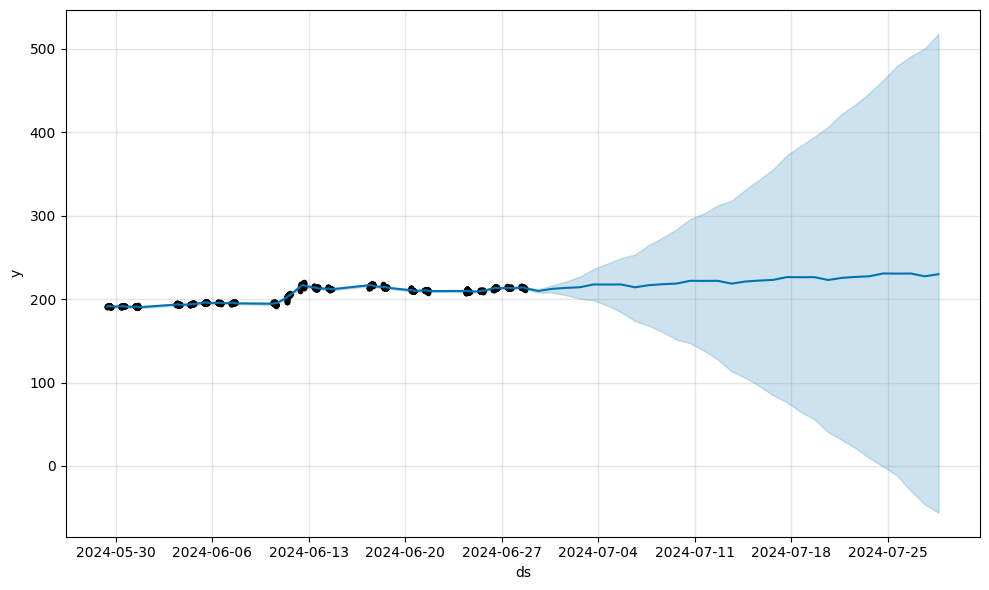

In [57]:
#Prophet
def prophet_forecast(df):
    # Select only the necessary columns
    df = df[['Datetime', 'Close']]

    # Rename the columns to match Prophet's requirements
    df = df.rename(columns={'Datetime': 'ds', 'Close': 'y'})

    # Ensure the 'ds' column is of datetime type and remove timezone
    df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)

    # Create a Prophet model
    model = Prophet()

    # Fit the model to the data  ################ shouldn't it be all data? ################
    model.fit(df)

    # Make a forecast for the next 30 days
    future = model.make_future_dataframe(periods=30)

    # Make predictions on the future dataframe
    forecast = model.predict(future)

    # Print the forecasted values
    #print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30))

    # Plot the forecast
    model.plot(forecast)

ticker = 'AAPL'
combined_df = get_numeric_data(ticker)
prophet_forecast(combined_df)

Epoch 1/100
3/3 - 5s - loss: 0.5401 - 5s/epoch - 2s/step
Epoch 2/100
3/3 - 0s - loss: 0.2499 - 151ms/epoch - 50ms/step
Epoch 3/100
3/3 - 0s - loss: 0.0487 - 162ms/epoch - 54ms/step
Epoch 4/100
3/3 - 0s - loss: 0.0626 - 186ms/epoch - 62ms/step
Epoch 5/100
3/3 - 0s - loss: 0.0400 - 165ms/epoch - 55ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0156 - 188ms/epoch - 63ms/step
Epoch 7/100
3/3 - 0s - loss: 0.0264 - 168ms/epoch - 56ms/step
Epoch 8/100
3/3 - 0s - loss: 0.0278 - 158ms/epoch - 53ms/step
Epoch 9/100
3/3 - 0s - loss: 0.0181 - 160ms/epoch - 53ms/step
Epoch 10/100
3/3 - 0s - loss: 0.0118 - 185ms/epoch - 62ms/step
Epoch 11/100
3/3 - 0s - loss: 0.0177 - 172ms/epoch - 57ms/step
Epoch 12/100
3/3 - 0s - loss: 0.0152 - 168ms/epoch - 56ms/step
Epoch 13/100
3/3 - 0s - loss: 0.0136 - 171ms/epoch - 57ms/step
Epoch 14/100
3/3 - 0s - loss: 0.0097 - 180ms/epoch - 60ms/step
Epoch 15/100
3/3 - 0s - loss: 0.0125 - 165ms/epoch - 55ms/step
Epoch 16/100
3/3 - 0s - loss: 0.0128 - 215ms/epoch - 72ms/step
Epoch 

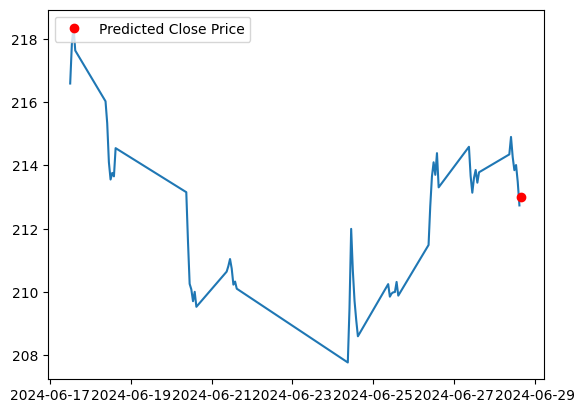

In [58]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt

def lstm_forcast(combined_df):

  # Load the data
  df = combined_df.copy()

  # Convert the Datetime column to datetime format
  df['Datetime'] = pd.to_datetime(df['Datetime'])

  # Set the Datetime column as the index
  df.set_index(df['Datetime'], inplace=True)


  # Drop any rows with missing values
  df_resampled.dropna(inplace=True)

  # Create a new dataframe with only the Close column
  close_df = df_resampled[['Close']]

  # Scale the data using Min-Max Scaler
  scaler = MinMaxScaler(feature_range=(0,1))
  close_scaled = scaler.fit_transform(close_df)

  # Create a function to create the LSTM dataset
  def create_lstm_dataset(X, y, time_steps=1):
      Xs, ys = [], []
      for i in range(len(X)-time_steps):
          Xs.append(X[i:(i+time_steps)])
          ys.append(y[i+time_steps])
      return np.array(Xs), np.array(ys)

  # Create the LSTM dataset
  X, y = create_lstm_dataset(close_scaled, close_scaled, time_steps=60)

  # Reshape the data for LSTM
  X = X.reshape(X.shape[0], X.shape[1], 1)

  # Create the LSTM model
  model = Sequential()
  model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
  model.add(Dropout(0.2))
  model.add(LSTM(units=50, return_sequences=False))
  model.add(Dropout(0.2))
  model.add(Dense(units=1))

  # Compile the model
  model.compile(optimizer='adam', loss='mean_squared_error')

  # Train the model
  model.fit(X, y, epochs=100, batch_size=32, verbose=2)

  # Make predictions on the last 60 hours of data
  last_60_hours = close_scaled[-60:]
  last_60_hours = last_60_hours.reshape(1, 60, 1)
  prediction = model.predict(last_60_hours)

  # Inverse transform the prediction
  prediction = scaler.inverse_transform(prediction)

  # Print the predicted close price
  print("Predicted Close Price:", prediction[0][0])

  # Plot the predicted close price
  plt.plot(close_df.index[-60:], close_df.values[-60:])
  plt.plot([close_df.index[-1] + pd.Timedelta(hours=1)], [prediction[0][0]], 'ro', label='Predicted Close Price')
  plt.legend(loc='upper left')
  plt.show()

combined_df = concat_numeric_sentiments(numeric_df, sentiments_df)
lstm_forcast(combined_df)

In [96]:
combined_df = concat_numeric_sentiments(numeric_df, sentiments_df)
df = combined_df.copy()
df.drop('headline', axis = 1, inplace = True)

# Convert the Datetime column to datetime format
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Move the Datetime column to the first position
cols = df.columns.tolist()
cols.insert(0, cols.pop(cols.index('Datetime')))
df = df[cols]

# Create a new dataframe with only the relevant columns
relevant_cols = ['Open', 'High', 'Low', 'Close', 'Volume',
                  #'MA_50', 'MA_200',
                  #'RSI',
                 'ensemble_sentiment', 'ensemble_sentiment_std']
data_df = df[relevant_cols]

# Drop NaN values
data_df.dropna(inplace=True)

data_df.head()

<ipython-input-96-168f4d049602>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df.dropna(inplace=True)


,Open,High,Low,Close,Volume,ensemble_sentiment,ensemble_sentiment_std
0,189.509995,190.720001,189.509995,190.600006,2858977,0.413585,0.293317
1,190.580002,191.389999,190.460007,191.110001,1537401,0.244723,0.204261
2,191.110001,191.199997,190.929993,191.085007,906534,0.264398,0.098636
3,191.089996,191.820007,191.039993,191.589996,1267157,0.733650,0.205430
4,191.580002,192.246994,191.570007,192.089996,1554915,0.439582,0.335019


Epoch 1/50
41/41 [==============================] - 12s 107ms/step - loss: nan - val_loss: nan
Epoch 2/50
41/41 [==============================] - 4s 95ms/step - loss: nan - val_loss: nan
Epoch 3/50
41/41 [==============================] - 7s 178ms/step - loss: nan - val_loss: nan
Epoch 4/50
41/41 [==============================] - 4s 107ms/step - loss: nan - val_loss: nan
Epoch 5/50
41/41 [==============================] - 4s 93ms/step - loss: nan - val_loss: nan
Epoch 6/50
41/41 [==============================] - 4s 107ms/step - loss: nan - val_loss: nan
Epoch 7/50
41/41 [==============================] - 4s 92ms/step - loss: nan - val_loss: nan
Epoch 8/50
41/41 [==============================] - 4s 95ms/step - loss: nan - val_loss: nan
Epoch 9/50
41/41 [==============================] - 5s 122ms/step - loss: nan - val_loss: nan
Epoch 10/50
41/41 [==============================] - 4s 90ms/step - loss: nan - val_loss: nan
Epoch 11/50
41/41 [==============================] - 3s 86ms/st

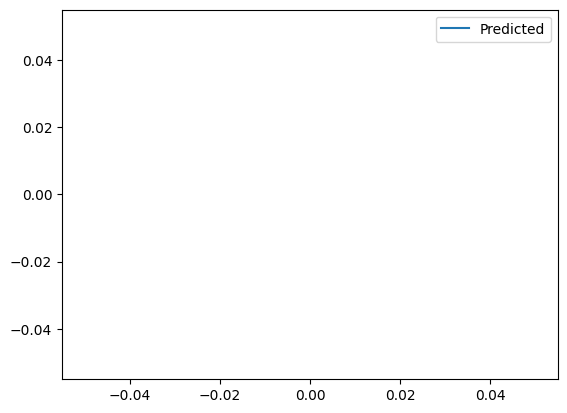

In [98]:
#GRU
def gru_forcast(combined_df):
  # Load the data
  df = combined_df.copy()
  df.drop('headline', axis = 1, inplace = True)

  # Convert the Datetime column to datetime format
  df['Datetime'] = pd.to_datetime(df['Datetime'])

  # Move the Datetime column to the first position
  cols = df.columns.tolist()
  cols.insert(0, cols.pop(cols.index('Datetime')))
  df = df[cols]

  # Create a new dataframe with only the relevant columns
  relevant_cols = ['Open', 'High', 'Low', 'Close', 'Volume',
                    'MA_50', 'MA_200', 'RSI',
                  'ensemble_sentiment', 'ensemble_sentiment_std']
  data_df = df[relevant_cols]

  # Drop NaN values
  #data_df.dropna(inplace=True) ##################can't deal with NaN values, it's in the technical indicators and "not enough" sentiments

  # Scale the data
  scaler = MinMaxScaler(feature_range=(0,1))
  scaled_data = scaler.fit_transform(data_df)

  # Split the data into training and testing sets
  train_size = int(len(scaled_data) * 0.8)
  test_size = len(scaled_data) - train_size
  train_data, test_data = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

  # Convert the data into sequences
  def create_sequences(data, seq_len):
      X, y = [], []
      for i in range(len(data) - seq_len):
          X.append(data[i:i+seq_len])
          y.append(data[i+seq_len])
      return np.array(X), np.array(y)

  seq_len = 60
  X_train, y_train = create_sequences(train_data, seq_len)
  X_test, y_test = create_sequences(test_data, seq_len)

  # Reshape the data for GRU
  X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
  X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

  # Create the GRU model
  model = Sequential()
  model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.2))
  model.add(GRU(units=50, return_sequences=False))
  model.add(Dropout(0.2))
  model.add(Dense(units=1))

  # Compile the model
  model.compile(optimizer='adam', loss='mean_squared_error')

  # Train the model
  model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

  # Make predictions
  predictions = model.predict(X_test)

  # Plot the results
  #plt.plot(y_test, label='Actual')
  plt.plot(predictions, label='Predicted')
  plt.legend()
  plt.show()

combined_df = concat_numeric_sentiments(numeric_df, sentiments_df)
gru_forcast(combined_df)

### Ensembling

## Agregation with telegram

In [ ]:
def send_prediction(ticker, prediction):
    TOKEN = "" ######## Telegram Token ##########
    chat_id = "" ######## Telegram Token ##########
    message = f"Predicted stock price for {ticker}: {round(prediction, 2)}"

    url = f"https://api.telegram.org/bot{TOKEN}/sendMessage?chat_id={chat_id}&text={message}"

    requests.get(url).json()

## Pipeline
- need seperate sections (???) so that the repeater doesn't keep pulling

In [ ]:
def prediction_pipeline():
  ticker = 'AAPL'
  num_articles = 5
  articles = scrape_news_articles(ticker, num_articles) #note the change in name
  sentiments = analyze_news_sentiment(articles)
  prediction = make_stock_price_prediction(ticker, sentiments)
  send_prediction(ticker, prediction)
  print(f"\nPredicted stock price for {ticker}: {round(prediction, 2)}")
  pass
prediction_pipeline()